In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset/"

train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)

validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


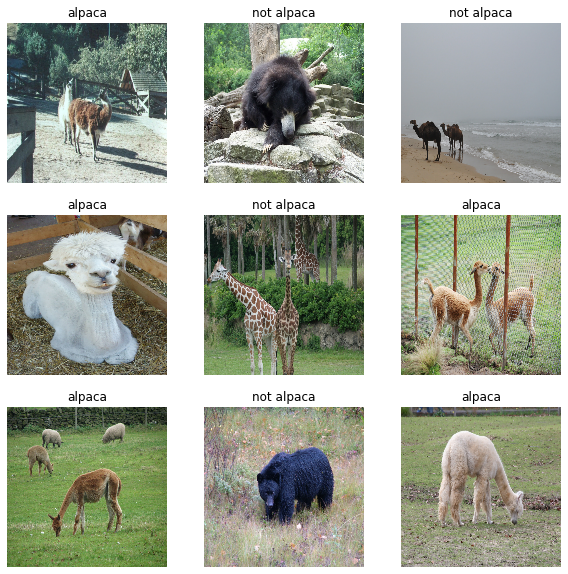

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(2):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [4]:
print("train_dataset: ", train_dataset)
print("validation_dataset: ", validation_dataset)

train_dataset:  <BatchDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int32)>
validation_dataset:  <BatchDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int32)>


In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

# Using prefetch() prevents a memory bottleneck that can occur when reading from disk.
# You can set the number of elements to prefetch manually, or you can use tf.data.experimental.AUTOTUNE to choose the parameters automatically. 

In [6]:
# Data Augmentation: https://www.tensorflow.org/tutorials/images/data_augmentation
def data_augmenter():
    '''
    a Sequential model composed of 2 layers
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal"))
    data_augmentation.add(RandomRotation(0.2))
    
    return data_augmentation # type: tf.keras.Sequential

In [7]:
data_augmentation = data_augmenter()
print(type(data_augmentation))

<class 'tensorflow.python.keras.engine.sequential.Sequential'>


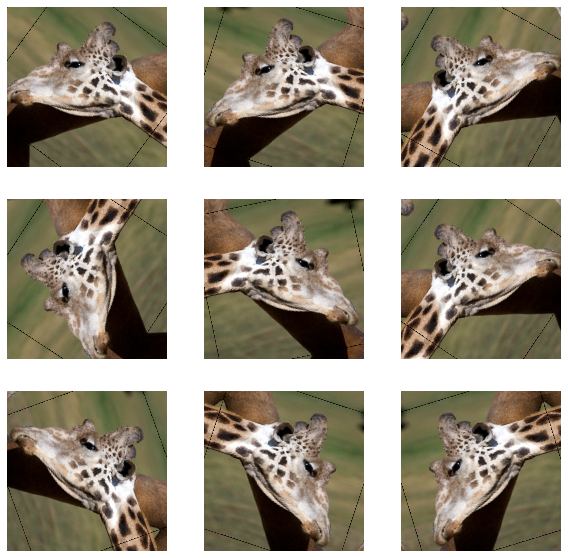

In [8]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Since we are using a pre-trained model that was trained on the normalization values [-1,1], it's best practice to reuse that standard with tf.keras.applications.mobilenet_v2.preprocess_input
# https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2/preprocess_input

In [10]:
IMG_SHAPE = IMG_SIZE + (3,)
print("IMG_SIZE: ", IMG_SIZE)
print("IMG_SHAPE: ", IMG_SHAPE)

IMG_SIZE:  (160, 160)
IMG_SHAPE:  (160, 160, 3)


In [11]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

# https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html

In [12]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

**Last 2 layers, aka top layers, responsible of the classification in the model**

In [13]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


In [14]:
# Choosing the first batch and running it through the MobileNetV2base model to test out some predictions
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print("image_batch: ", image_batch)
print("label_batch: ", label_batch)
print("feature_batch: ", feature_batch)
print(feature_batch.shape)

image_batch:  tf.Tensor(
[[[[1.72369995e+02 1.70639999e+02 1.08970001e+02]
   [1.67800003e+02 1.63790009e+02 1.17199997e+02]
   [1.47550003e+02 1.45550003e+02 1.00050003e+02]
   ...
   [8.48499985e+01 3.82999992e+01 1.30500002e+01]
   [9.67900009e+01 4.59699593e+01 1.50799809e+01]
   [1.01660011e+02 4.84600105e+01 1.47600098e+01]]

  [[1.75399994e+02 1.75399994e+02 1.02800003e+02]
   [1.72399994e+02 1.69029999e+02 1.19169998e+02]
   [1.46850006e+02 1.44850006e+02 9.93499985e+01]
   ...
   [7.49000015e+01 3.51500015e+01 2.99999714e-01]
   [9.66699829e+01 5.21299667e+01 1.53999748e+01]
   [9.33000107e+01 4.52100143e+01 5.21001530e+00]]

  [[1.80750000e+02 1.78899994e+02 1.19150002e+02]
   [1.72949997e+02 1.68949997e+02 1.21399994e+02]
   [1.44000000e+02 1.42500000e+02 9.35000000e+01]
   ...
   [5.92500000e+01 2.45000000e+01 0.00000000e+00]
   [7.78500366e+01 3.78500366e+01 6.35003662e+00]
   [8.00000000e+01 3.61499939e+01 3.05001831e+00]]

  ...

  [[5.75000000e+01 5.75000000e+01 5.85000

In [15]:
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0])>

In [16]:
base_model.trainable = False
image_var = tf.Variable(image_batch)
pred = base_model(image_var)

#Decoding the predictions made by the model.
tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

# It will print:
# (class number, label, probability of the image belonging to that class)
# For each image, two of these returned which are the top two probabilities returned for that image.

[[('n04589890', 'window_screen', 0.4258215),
  ('n02708093', 'analog_clock', 0.0927568)],
 [('n04589890', 'window_screen', 0.23985834),
  ('n03887697', 'paper_towel', 0.14802766)],
 [('n04589890', 'window_screen', 0.7449433),
  ('n03598930', 'jigsaw_puzzle', 0.021948956)],
 [('n04589890', 'window_screen', 0.33545944),
  ('n03530642', 'honeycomb', 0.076290205)],
 [('n04589890', 'window_screen', 0.2732714),
  ('n03733281', 'maze', 0.08847068)],
 [('n04589890', 'window_screen', 0.67452323),
  ('n03530642', 'honeycomb', 0.07659925)],
 [('n04589890', 'window_screen', 0.7912847),
  ('n04209239', 'shower_curtain', 0.09241659)],
 [('n04589890', 'window_screen', 0.1646283),
  ('n03598930', 'jigsaw_puzzle', 0.08749186)],
 [('n03598930', 'jigsaw_puzzle', 0.37021255),
  ('n04589890', 'window_screen', 0.099570304)],
 [('n04589890', 'window_screen', 0.6161616),
  ('n03887697', 'paper_towel', 0.05487736)],
 [('n03530642', 'honeycomb', 0.25448912),
  ('n04589890', 'window_screen', 0.24874341)],
 [('n0

In [17]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):

    input_shape = image_shape + (3,)
    
    # Deleting the top layer (the classification layer) in order to label "alpaca"/"not alpaca" correctly via include_top = False
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    
    # Freezing the base model -- to avoid changing the weights and train only the new layer
    base_model.trainable = False
    
    # Creating the input layer
    inputs = tf.keras.Input(shape=input_shape) 
    
    # Data augmentation for the inputs
    x = data_augmentation(inputs)
    
    # Data preprocessing using the same weights the model was trained on
    # preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    x = preprocess_input(x) 
    
    # Setting training as False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # Adding the new binary classification layers
    # Global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    
    # Dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # Prediction layer with one neuron
    prediction_layer = tfl.Dense(1)
    
    outputs = prediction_layer(x) 
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [18]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

In [19]:
base_learning_rate = 0.01
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# BinaryCrossentropy class: https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class
# Use this cross-entropy loss for binary (0 or 1) classification applications..

# metrics=['accuracy']
# When you pass the strings 'accuracy' or 'acc', we convert this to one of tf.keras.metrics.BinaryAccuracy, tf.keras.metrics.CategoricalAccuracy, 
# tf.keras.metrics.SparseCategoricalAccuracy based on the loss function used and the model output shape. 
# We do a similar conversion for the strings 'crossentropy' and 'ce' as well.

In [20]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 [==============================] - 7s 805ms/step - loss: 1.1945 - accuracy: 0.5802 - val_loss: 0.2768 - val_accuracy: 0.8308
Epoch 2/5
9/9 [==============================] - 6s 686ms/step - loss: 0.5868 - accuracy: 0.7786 - val_loss: 0.4224 - val_accuracy: 0.7692
Epoch 3/5
9/9 [==============================] - 6s 713ms/step - loss: 0.3212 - accuracy: 0.8435 - val_loss: 0.2086 - val_accuracy: 0.9077
Epoch 4/5
9/9 [==============================] - 6s 710ms/step - loss: 0.2925 - accuracy: 0.8435 - val_loss: 0.0935 - val_accuracy: 0.9692
Epoch 5/5
9/9 [==============================] - 7s 736ms/step - loss: 0.2266 - accuracy: 0.9084 - val_loss: 0.1161 - val_accuracy: 0.9385


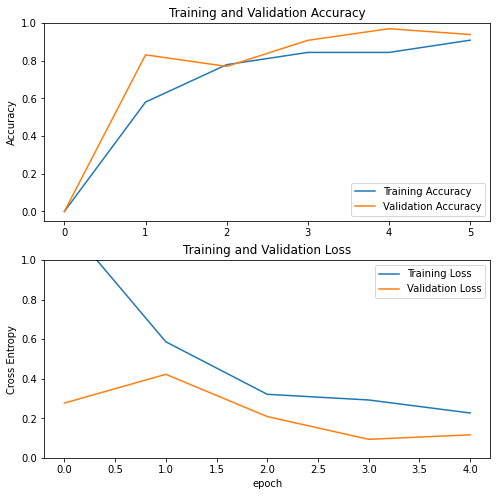

In [21]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [22]:
class_names

['alpaca', 'not alpaca']

Fine-tuning

In [23]:
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 126

# Freezing all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Defining a BinaryCrossentropy loss function with "from_logits=True". 
# from_logits --> whether to interpret y_pred as a tensor of logit values. By default, we assume that y_pred contains probabilities (i.e., values in [-inf, inf] when from_logits=True, value in [0, 1] when from_logits=False)
# https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy
loss_function= tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1*base_learning_rate)

# 'accuracy' as evaluation metric
metrics=['accuracy']

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  157


In [24]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
9/9 [==============================] - 7s 821ms/step - loss: 0.1984 - accuracy: 0.9084 - val_loss: 0.0980 - val_accuracy: 0.9538
Epoch 6/10
9/9 [==============================] - 6s 699ms/step - loss: 0.1985 - accuracy: 0.9198 - val_loss: 0.1082 - val_accuracy: 0.9385
Epoch 7/10
9/9 [==============================] - 6s 720ms/step - loss: 0.1913 - accuracy: 0.9084 - val_loss: 0.1006 - val_accuracy: 0.9385
Epoch 8/10
9/9 [==============================] - 7s 738ms/step - loss: 0.2200 - accuracy: 0.8893 - val_loss: 0.1079 - val_accuracy: 0.9385
Epoch 9/10
9/9 [==============================] - 6s 682ms/step - loss: 0.1893 - accuracy: 0.9237 - val_loss: 0.0923 - val_accuracy: 0.9538
Epoch 10/10
9/9 [==============================] - 7s 747ms/step - loss: 0.1625 - accuracy: 0.9313 - val_loss: 0.0966 - val_accuracy: 0.9538


In [25]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

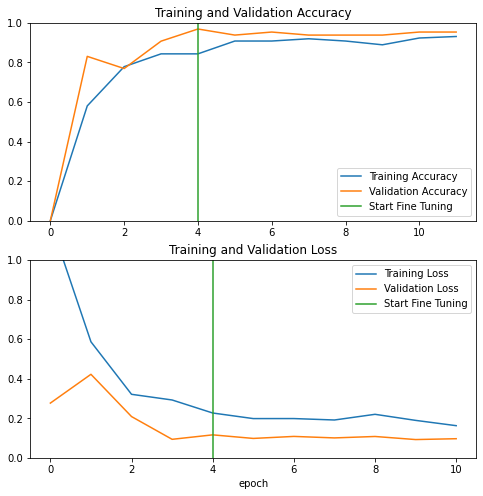

In [26]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()